In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import MultiTaskLassoCV
import matplotlib.pyplot as plt

In [2]:
# Create the feature matrix X
def create_feature_matrix(data, lags=[1, 2]):
    X = pd.DataFrame()
    for lag in lags:
        for ticker in data.columns:
            X[f'{ticker}_lag_{lag}'] = data[ticker].shift(lag)
    X = X.dropna()
    return X

In [3]:
# Split data into training and testing sets
def split_data(X, y):
    mid_point = len(X) // 2
    X_train, X_test = X[:mid_point], X[mid_point:]
    y_train, y_test = y[:mid_point], y[mid_point:]
    return X_train, X_test, y_train, y_test

In [4]:
# Calculate gamma for prediction intervals
def calculate_gamma(y_train2, predicted_train2, alpha=0.1):
    y_train2_shifted = pd.DataFrame(y_train2).shift(1).dropna().values
    residuals = np.abs(y_train2[1:] - predicted_train2[1:]) / y_train2_shifted  # Calculate residuals for each target ticker
    sorted_residuals = np.sort(residuals, axis=0)  # Sort residuals along the time axis for each ticker
    gamma_index = int(np.ceil((1 - alpha) * (len(sorted_residuals)) + 1))  # Index for gamma
    gamma = sorted_residuals[min(gamma_index - 1, len(sorted_residuals) - 1), :]  # Selecting gamma for each target ticker
    return gamma

In [5]:
# Function to evaluate model for given tickers and a target ticker
def evaluate_model(target_tickers, all_data, fixed_tickers, additional_tickers):
    results = []
    for k in range(0, 21):  # Loop to include up to 10 additional tickers
        tickers_used = fixed_tickers + additional_tickers[:k]
       # if len(tickers_used) > 20:  # Stop after processing 20 tickers
        #    break
        try:
            print(f"Evaluating {len(tickers_used)} tickers for targets {target_tickers}: {tickers_used}")
            data_used = all_data[tickers_used]

            # Create the feature matrix using the selected tickers
            X = create_feature_matrix(data_used)
            y = all_data[target_tickers].loc[X.index]

            print(f"Data used shape: {data_used.shape}")
            print(f"Feature matrix shape: {X.shape}")

            if X.empty or y.empty:
                print(f"Skipping {len(tickers_used)} tickers: Empty DataFrame")
                continue

            # Adding additional features to X
            new_features = {}
            for ticker in tickers_used:
                if f'{ticker}_lag_1' in X.columns and f'{ticker}_lag_2' in X.columns:
                    diff_squared = (X[f'{ticker}_lag_1'] - X[f'{ticker}_lag_2']) ** 2
                    volatility = (X[f'{ticker}_lag_1'] - X[f'{ticker}_lag_2']) / X[f'{ticker}_lag_2']
                    new_features[f'{ticker}_diff_squared'] = diff_squared
                    new_features[f'{ticker}_volatility'] = volatility

            if new_features:
                new_features_df = pd.DataFrame(new_features, index=X.index)
                X = pd.concat([X, new_features_df], axis=1)
                X = X.copy()  # Create a de-fragmented copy of the DataFrame

            print(f"Feature matrix after adding new features shape: {X.shape}")

            # Splitting the data
            X_train, X_test, y_train, y_test = split_data(X, y)

            print(f"Train/Test split shapes: {X_train.shape}, {X_test.shape}")

            if X_train.empty or y_train.empty or X_test.empty or y_test.empty:
                print(f"Skipping {len(tickers_used)} tickers: Empty train/test split")
                continue

            # Splitting X_train into train1 (90%) and train2 (10%)
            train1_end = int(len(X_train) * 0.9)
            X_train1, X_train2 = X_train[:train1_end], X_train[train1_end:]
            y_train1, y_train2 = y_train[:train1_end], y_train[train1_end:]

            # Feature scaling
            scaler_X = StandardScaler().fit(X_train1)
            X_train1_scaled = scaler_X.transform(X_train1)
            X_train2_scaled = scaler_X.transform(X_train2)
            X_test_scaled = scaler_X.transform(X_test)

            scaler_Y = StandardScaler().fit(y_train1)
            y_train1_scaled = scaler_Y.transform(y_train1)
            y_train2_scaled = scaler_Y.transform(y_train2)
            y_test_scaled = scaler_Y.transform(y_test)

            # Debugging: Check the scaled values
            print(f"Scaled y_train1: {y_train1_scaled[:5]}")
            print(f"Scaled y_train2: {y_train2_scaled[:5]}")
            print(f"Scaled y_test: {y_test_scaled[:5]}")

            # Machine learning model with regularization
            multitask_lasso = MultiTaskLassoCV(max_iter=10000)  # Changed to MultiTaskLassoCV
            multitask_lasso.fit(X_train1_scaled, y_train1_scaled)

            # Predict using the model
            predicted_train1_scaled = multitask_lasso.predict(X_train1_scaled)
            predicted_train2_scaled = multitask_lasso.predict(X_train2_scaled)
            predicted_test_scaled = multitask_lasso.predict(X_test_scaled)

            # Compute Mean Squared Error (MSE)
            mse_train1 = np.mean(np.power(y_train1_scaled - predicted_train1_scaled, 2), axis=0)
            mse_train2 = np.mean(np.power(y_train2_scaled - predicted_train2_scaled, 2), axis=0)
            mse_test = np.mean(np.power(y_test_scaled - predicted_test_scaled, 2), axis=0)

            # Log MSE values
            print(f"MSE Train1: {mse_train1}, MSE Train2: {mse_train2}, MSE Test: {mse_test}")

            # Ensure arrays are 2D before inverse transforming
            predicted_train1_scaled = predicted_train1_scaled.reshape(-1, len(target_tickers))
            predicted_train2_scaled = predicted_train2_scaled.reshape(-1, len(target_tickers))
            predicted_test_scaled = predicted_test_scaled.reshape(-1, len(target_tickers))

            # Inverse transform the scaled predictions and actual values
            predicted_train1 = scaler_Y.inverse_transform(predicted_train1_scaled)
            predicted_train2 = scaler_Y.inverse_transform(predicted_train2_scaled)
            predicted_test = scaler_Y.inverse_transform(predicted_test_scaled)
            y_train1_inv = scaler_Y.inverse_transform(y_train1_scaled)
            y_train2_inv = scaler_Y.inverse_transform(y_train2_scaled)
            y_test_inv = scaler_Y.inverse_transform(y_test_scaled)

            # Calculate gamma for prediction intervals
            gamma = calculate_gamma(y_train2_inv, predicted_train2)
            gamma = np.mean(gamma)  # Ensure gamma is the same for all target tickers

            # Evaluate direction accuracy
            direction_accuracy_train1 = np.mean((np.sign(np.diff(y_train1.values, axis=0)) == np.sign(np.diff(predicted_train1, axis=0))).astype(int), axis=0)
            direction_accuracy_train2 = np.mean((np.sign(np.diff(y_train2.values, axis=0)) == np.sign(np.diff(predicted_train2, axis=0))).astype(int), axis=0)
            direction_accuracy_test = np.mean((np.sign(np.diff(y_test.values, axis=0)) == np.sign(np.diff(predicted_test, axis=0))).astype(int), axis=0)

            print(f"Processed {len(tickers_used)} tickers")

            # Predictions and actual values for plotting
            predictions = {
                'y_train1': y_train1_inv,
                'y_train2': y_train2_inv,
                'y_test': y_test_inv,
                'predicted_train1': predicted_train1,
                'predicted_train2': predicted_train2,
                'predicted_test': predicted_test,
                'gamma': gamma
            }

            for i, target in enumerate(target_tickers):
                results.append({
                    'Num_Tickers': len(tickers_used),
                    'Target_Ticker': target,
                    'MSE_Train1': mse_train1[i],
                    'MSE_Train2': mse_train2[i],
                    'MSE_Test': mse_test[i],
                    'Direction_Accuracy_Train1': direction_accuracy_train1[i],
                    'Direction_Accuracy_Train2': direction_accuracy_train2[i],
                    'Direction_Accuracy_Test': direction_accuracy_test[i],
                    'Predictions': {key: value[:, i] if key != 'gamma' else value for key, value in predictions.items()}
                })

        except Exception as e:
            print(f"Error processing {len(tickers_used)} tickers: {e}")
            continue

    return results


In [6]:
# Function to plot actual vs predicted stock prices
def plot_actual_vs_predicted(predictions, target):
    gamma = predictions['gamma']
    y_test_lagged = pd.Series(predictions['y_test']).shift(1).dropna().values
    y_test = predictions['y_test'][1:]  # Adjust y_test to match the shifted values

    upper_bounds = predictions['predicted_test'][1:] + (gamma * y_test_lagged)
    lower_bounds = predictions['predicted_test'][1:] - (gamma * y_test_lagged)

    plt.figure(figsize=(14, 7))
    plt.plot(predictions['y_train1'], label='Actual Train1', color='black', linestyle='dashed')
    plt.plot(predictions['predicted_train1'], label='Predicted Train1', color='blue')
    plt.plot(range(len(predictions['y_train1']), len(predictions['y_train1']) + len(predictions['y_train2'])), predictions['y_train2'], label='Actual Train2', color='gray', linestyle='dashed')
    plt.plot(range(len(predictions['y_train1']), len(predictions['y_train1']) + len(predictions['y_train2'])), predictions['predicted_train2'], label='Predicted Train2', color='cyan')
    plt.plot(range(len(predictions['y_train1']) + len(predictions['y_train2']), len(predictions['y_train1']) + len(predictions['y_train2']) + len(y_test)), y_test, label='Actual Test', color='black', linestyle='dashed')
    plt.plot(range(len(predictions['y_train1']) + len(predictions['y_train2']), len(predictions['y_train1']) + len(predictions['y_train2']) + len(y_test)), predictions['predicted_test'][1:], label='Predicted Test', color='red')
    plt.fill_between(range(len(predictions['y_train1']) + len(predictions['y_train2']), len(predictions['y_train1']) + len(predictions['y_train2']) + len(y_test)), lower_bounds.flatten(), upper_bounds.flatten(), color='orange', alpha=0.3, label='Prediction Interval')

    plt.xlabel('Days')
    plt.ylabel('Stock Price')
    plt.title(f'Actual vs Predicted Stock Prices for {target}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate coverage for the entire test period
    coverage_full = np.mean((y_test >= lower_bounds) & (y_test <= upper_bounds))
    print(f"Coverage for the entire test period: {coverage_full * 100:.2f}%")

    # Calculate coverage for the first 10% of the test period
    test_10_percent = int(0.1 * len(y_test))
    coverage_10_percent = np.mean((y_test[:test_10_percent] >= lower_bounds[:test_10_percent]) & (y_test[:test_10_percent] <= upper_bounds[:test_10_percent]))
    print(f"Coverage for the first 10% of the test period: {coverage_10_percent * 100:.2f}%")

ticker_list = ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL', 'ECL', 'APD', 'SHW', 'ICE', 'LMT', 'LRCX', 'ETN', 'FDX', 'VRTX', 'MPC', 'TGT', 'BMY', 'NSC', 'CI', 'REGN', 'DD', 'TRV', 'CMG', 'AON', 'F', 'GM', 'APTV', 'APH', 'CDW', 'KMB', 'BSX']


In [7]:
# Download data for all tickers
all_data = yf.download(ticker_list, start='2010-06-29', end='2014-06-24')['Adj Close']

[*********************100%%**********************]  94 of 94 completed


In [8]:
# Fill missing values and forward-fill any remaining missing data
all_data.ffill(inplace=True)
all_data.bfill(inplace=True)

In [9]:
# Evaluate models for different number of tickers in the feature matrix
fixed_tickers = ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'MRK', 'ABT', 'ABBV', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'IBM', 'QCOM', 'HON', 'AMD', 'SBUX', 'AMGN', 'APTV']
additional_tickers = [ticker for ticker in ticker_list if ticker not in fixed_tickers]
target_tickers = ['GOOGL', 'AAPL', 'AMZN', 'NVDA', 'NFLX', 'V', 'JPM', 'MSFT', 'DIS', 'UNH', 'PEP', 'CSCO', 'IBM', 'QCOM', 'AMD', 'SBUX', 'AMGN', 'APTV']

In [10]:
results = evaluate_model(target_tickers, all_data, fixed_tickers, additional_tickers)

# Check the structure of results
print("Results Structure:", results)


Evaluating 36 tickers for targets ['GOOGL', 'AAPL', 'AMZN', 'NVDA', 'NFLX', 'V', 'JPM', 'MSFT', 'DIS', 'UNH', 'PEP', 'CSCO', 'IBM', 'QCOM', 'AMD', 'SBUX', 'AMGN', 'APTV']: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'MRK', 'ABT', 'ABBV', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'IBM', 'QCOM', 'HON', 'AMD', 'SBUX', 'AMGN', 'APTV']
Data used shape: (1003, 36)
Feature matrix shape: (1001, 72)
Feature matrix after adding new features shape: (1001, 144)
Train/Test split shapes: (500, 144), (501, 144)
Scaled y_train1: [[-2.41185821 -1.41361512 -2.54577301 -1.32153823 -0.92777823 -0.85757077
  -0.82608768 -1.66137409 -1.65531502 -2.13762235 -2.15520063  0.86581607
  -1.86688131 -2.68617837  0.20185127 -1.49281811 -1.06991207 -0.38794219]
 [-2.46730106 -1.43219458 -2.61112059 -1.35798757 -0.9688934  -0.83574569
  -0.88074892 -1.61641377 -1.6828836  -2.08079584 -2.15116847  0.81360645
  -1.8

C:\Users\kantr\AppData\Local\Temp\ipykernel_13348\1627866829.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'{ticker}_lag_{lag}'] = data[ticker].shift(lag)
C:\Users\kantr\AppData\Local\Temp\ipykernel_13348\1627866829.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'{ticker}_lag_{lag}'] = data[ticker].shift(lag)


MSE Train1: [0.02439012 0.00375182 0.01561269 0.01347349 0.00695184 0.0080788
 0.02174604 0.01534867 0.01510258 0.00678818 0.04393336 0.01709194
 0.00559983 0.00920049 0.01996698 0.00511904 0.01265017 0.00469895], MSE Train2: [0.10912811 0.04616375 0.06441418 0.10400928 0.00515821 0.03475216
 0.47716757 0.05605071 0.2513968  0.02716163 0.12409052 0.06227714
 0.0388951  0.2257187  0.05126219 0.06251043 0.04215848 0.05349289], MSE Test: [0.61661261 2.50205805 5.51033842 0.15882516 0.17247122 1.22050078
 0.94207236 0.79633871 1.35427775 0.17515089 0.64851242 0.73511428
 0.44618357 0.26587475 0.30736636 0.44870599 0.96726573 2.34996494]
Processed 51 tickers
Evaluating 52 tickers for targets ['GOOGL', 'AAPL', 'AMZN', 'NVDA', 'NFLX', 'V', 'JPM', 'MSFT', 'DIS', 'UNH', 'PEP', 'CSCO', 'IBM', 'QCOM', 'AMD', 'SBUX', 'AMGN', 'APTV']: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'MRK', 'ABT', 'ABBV

C:\Users\kantr\AppData\Local\Temp\ipykernel_13348\1627866829.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'{ticker}_lag_{lag}'] = data[ticker].shift(lag)
C:\Users\kantr\AppData\Local\Temp\ipykernel_13348\1627866829.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'{ticker}_lag_{lag}'] = data[ticker].shift(lag)
C:\Users\kantr\AppData\Local\Temp\ipykernel_13348\1627866829.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfor

MSE Train1: [0.02389817 0.00364364 0.01546073 0.01330879 0.00688491 0.00789598
 0.02144134 0.0150741  0.01466901 0.00664282 0.04349946 0.0168168
 0.00547869 0.00891259 0.01964043 0.00496865 0.01233577 0.00464609], MSE Train2: [0.118445   0.04203061 0.06341932 0.10786316 0.006025   0.03545105
 0.48724373 0.05579309 0.27028068 0.02493084 0.11441838 0.06309234
 0.03795436 0.22715585 0.0519955  0.05677937 0.04404225 0.05434365], MSE Test: [0.97281697 2.11284519 5.45870465 0.17651332 0.22352167 1.03744885
 0.96773303 0.74678506 1.00350962 0.17091126 0.63586774 0.76908668
 0.5066762  0.21259703 0.4577119  0.37776744 0.88257524 2.39291444]
Processed 52 tickers
Evaluating 53 tickers for targets ['GOOGL', 'AAPL', 'AMZN', 'NVDA', 'NFLX', 'V', 'JPM', 'MSFT', 'DIS', 'UNH', 'PEP', 'CSCO', 'IBM', 'QCOM', 'AMD', 'SBUX', 'AMGN', 'APTV']: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'MRK', 'ABT', 'ABBV

C:\Users\kantr\AppData\Local\Temp\ipykernel_13348\1627866829.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'{ticker}_lag_{lag}'] = data[ticker].shift(lag)
C:\Users\kantr\AppData\Local\Temp\ipykernel_13348\1627866829.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'{ticker}_lag_{lag}'] = data[ticker].shift(lag)
C:\Users\kantr\AppData\Local\Temp\ipykernel_13348\1627866829.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfor

MSE Train1: [0.0238093  0.00359854 0.01537986 0.01299123 0.00687436 0.00789048
 0.02141992 0.01507359 0.0146065  0.00654092 0.0434206  0.01678637
 0.00548014 0.00890747 0.01964829 0.0049612  0.01227678 0.00460815], MSE Train2: [0.11695729 0.04403014 0.06129986 0.10963796 0.00571093 0.03550648
 0.491419   0.05559782 0.2666029  0.02681268 0.11708898 0.06132732
 0.03999943 0.22643945 0.05230319 0.05704069 0.04289685 0.05357735], MSE Test: [1.1085775  1.95697931 5.50971866 0.16752524 0.20781119 1.0812835
 0.82953401 0.74356412 0.86093518 0.14833412 0.82159179 0.69029218
 0.53322697 0.20975597 0.48846876 0.36746011 0.99507413 2.30697877]
Processed 53 tickers
Evaluating 54 tickers for targets ['GOOGL', 'AAPL', 'AMZN', 'NVDA', 'NFLX', 'V', 'JPM', 'MSFT', 'DIS', 'UNH', 'PEP', 'CSCO', 'IBM', 'QCOM', 'AMD', 'SBUX', 'AMGN', 'APTV']: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'MRK', 'ABT', 'ABBV

C:\Users\kantr\AppData\Local\Temp\ipykernel_13348\1627866829.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'{ticker}_lag_{lag}'] = data[ticker].shift(lag)
C:\Users\kantr\AppData\Local\Temp\ipykernel_13348\1627866829.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'{ticker}_lag_{lag}'] = data[ticker].shift(lag)
C:\Users\kantr\AppData\Local\Temp\ipykernel_13348\1627866829.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfor

MSE Train1: [0.02392611 0.00364267 0.01547972 0.01283757 0.00692546 0.00793736
 0.02146074 0.01519219 0.01470695 0.00663    0.04357034 0.01689778
 0.0055641  0.00897981 0.01976797 0.00503797 0.01236114 0.00465718], MSE Train2: [0.11521107 0.04487495 0.06069503 0.1080492  0.00553949 0.03468608
 0.47768738 0.05524343 0.27783604 0.02777664 0.11493348 0.0577873
 0.04142762 0.23471272 0.05009464 0.05966271 0.04223866 0.05282222], MSE Test: [1.09950221 1.99039083 5.50281613 0.15977187 0.17896062 1.13465225
 0.76538233 0.81028303 0.82603649 0.15625174 0.77102552 0.63315965
 0.54923539 0.24145416 0.52676439 0.36584121 0.97558274 2.37182677]
Processed 54 tickers
Evaluating 55 tickers for targets ['GOOGL', 'AAPL', 'AMZN', 'NVDA', 'NFLX', 'V', 'JPM', 'MSFT', 'DIS', 'UNH', 'PEP', 'CSCO', 'IBM', 'QCOM', 'AMD', 'SBUX', 'AMGN', 'APTV']: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'MRK', 'ABT', 'ABBV

C:\Users\kantr\AppData\Local\Temp\ipykernel_13348\1627866829.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'{ticker}_lag_{lag}'] = data[ticker].shift(lag)
C:\Users\kantr\AppData\Local\Temp\ipykernel_13348\1627866829.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'{ticker}_lag_{lag}'] = data[ticker].shift(lag)
C:\Users\kantr\AppData\Local\Temp\ipykernel_13348\1627866829.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfor

MSE Train1: [0.02350194 0.00354502 0.01504287 0.01266301 0.00686663 0.00773981
 0.02094536 0.01497319 0.0143976  0.00647038 0.0429238  0.01673665
 0.00542982 0.00879691 0.01941032 0.00490292 0.01216622 0.00453035], MSE Train2: [0.12640314 0.04244425 0.05612981 0.11787216 0.00589878 0.03460263
 0.51323541 0.05706781 0.24909575 0.02704456 0.09851757 0.06336541
 0.04462187 0.23367328 0.05202979 0.06219288 0.04262335 0.05198224], MSE Test: [1.05446316 1.99208461 5.50170372 0.16967363 0.20911655 0.9934967
 0.76622279 0.75850052 0.76579204 0.1541392  0.73010396 0.66199564
 0.54651063 0.22381502 0.50636156 0.35825862 0.96469958 2.3750864 ]
Processed 55 tickers
Evaluating 56 tickers for targets ['GOOGL', 'AAPL', 'AMZN', 'NVDA', 'NFLX', 'V', 'JPM', 'MSFT', 'DIS', 'UNH', 'PEP', 'CSCO', 'IBM', 'QCOM', 'AMD', 'SBUX', 'AMGN', 'APTV']: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'MRK', 'ABT', 'ABBV

C:\Users\kantr\AppData\Local\Temp\ipykernel_13348\1627866829.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'{ticker}_lag_{lag}'] = data[ticker].shift(lag)
C:\Users\kantr\AppData\Local\Temp\ipykernel_13348\1627866829.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'{ticker}_lag_{lag}'] = data[ticker].shift(lag)
C:\Users\kantr\AppData\Local\Temp\ipykernel_13348\1627866829.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfor

MSE Train1: [0.02339546 0.0035392  0.01496482 0.01243252 0.0068077  0.00767489
 0.02090084 0.01493999 0.01437725 0.00646012 0.04226734 0.01653356
 0.00542227 0.00877661 0.01934629 0.00485718 0.01209332 0.00451945], MSE Train2: [0.12712083 0.04205215 0.05612508 0.11810743 0.00548095 0.03439485
 0.50706114 0.05660965 0.24916011 0.02710063 0.09024592 0.06491333
 0.04692414 0.23301098 0.0516664  0.06320095 0.04309994 0.05149303], MSE Test: [1.01333984 1.99585932 5.3650997  0.17616396 0.20035683 1.01969151
 0.79218124 0.7303977  0.79489524 0.14843151 0.80940588 0.70651445
 0.54048067 0.22036696 0.49702781 0.38275909 0.94088204 2.40712545]
Processed 56 tickers
Results Structure: 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Results DataFrame Head:    Num_Tickers Target_Ticker  MSE_Train1  MSE_Train2  MSE_Test  \
0           36         GOOGL    0.025935    0.206577  1.219391   
1           36          AAPL    0.003785    0.033641  2.606598   
2           36          AMZN    0.016795    0.070909  3.718515   
3           36          NVDA    0.014502    0.124397  0.280071   
4           36          NFLX    0.007281    0.007927  0.149614   

   Direction_Accuracy_Train1  Direction_Accuracy_Train2  \
0                   0.579065                   0.408163   
1                   0.583519                   0.510204   
2                   0.534521                   0.448980   
3                   0.543430                   0.489796   
4                   0.541203                   0.530612   

   Direction_Accuracy_Test                                        Predictions  
0                    0.518  {'y_train1': [10.985639572143555, 10.912151336...  
1                    0.502  {'y_train1': [7.502791404724121, 7.4

,Num_Tickers,Target_Ticker,MSE_Train1,MSE_Train2,MSE_Test,Direction_Accuracy_Train1,Direction_Accuracy_Train2,Direction_Accuracy_Test,Predictions
0,36,GOOGL,0.025935,0.206577,1.219391,0.579065,0.408163,0.518,"{'y_train1': [10.985639572143555, 10.912151336..."
1,36,AAPL,0.003785,0.033641,2.606598,0.583519,0.510204,0.502,"{'y_train1': [7.502791404724121, 7.45628833770..."
2,36,AMZN,0.016795,0.070909,3.718515,0.534521,0.448980,0.494,"{'y_train1': [5.547999858856201, 5.45699977874..."
3,36,NVDA,0.014502,0.124397,0.280071,0.543430,0.489796,0.474,"{'y_train1': [0.2380203753709793, 0.2350393682..."
4,36,NFLX,0.007281,0.007927,0.149614,0.541203,0.530612,0.506,"{'y_train1': [15.665714263916016, 15.297142982..."
...,...,...,...,...,...,...,...,...,...
373,56,QCOM,0.008777,0.233011,0.220367,0.608018,0.489796,0.492,"{'y_train1': [22.278640747070312, 22.564443588..."
374,56,AMD,0.019346,0.051666,0.497028,0.599109,0.530612,0.474,"{'y_train1': [7.389999866485596, 7.17000007629..."
375,56,SBUX,0.004857,0.063201,0.382759,0.565702,0.408163,0.488,"{'y_train1': [9.608283042907715, 9.48749542236..."
376,56,AMGN,0.012093,0.043100,0.940882,0.536748,0.428571,0.468,"{'y_train1': [37.13209533691406, 36.9036788940..."


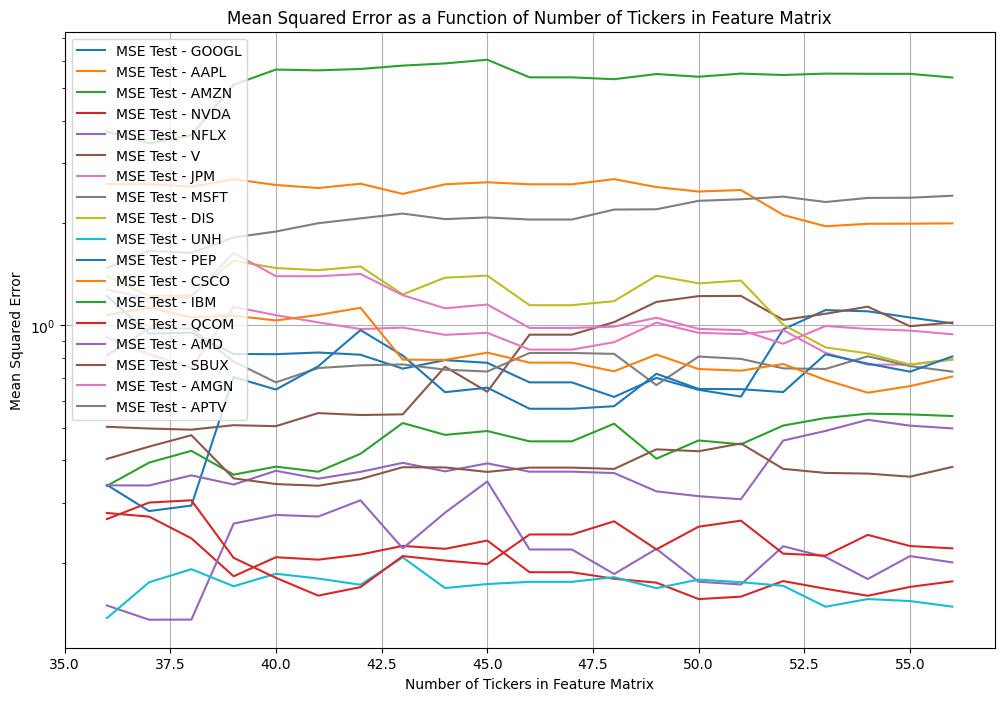

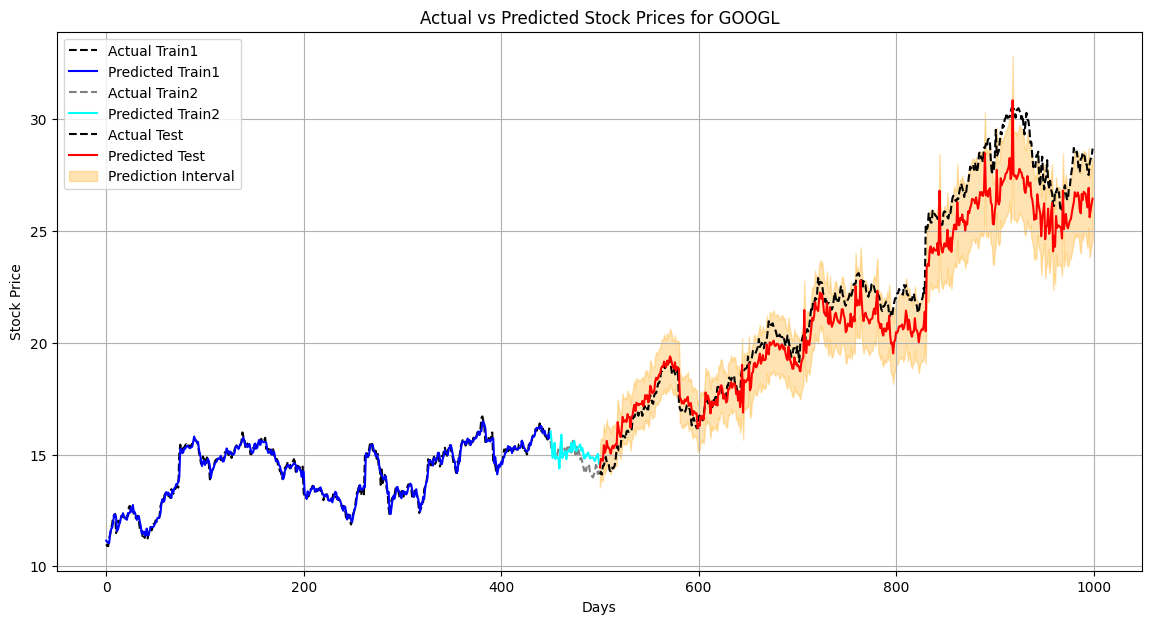

Coverage for the entire test period: 76.20%
Coverage for the first 10% of the test period: 96.00%


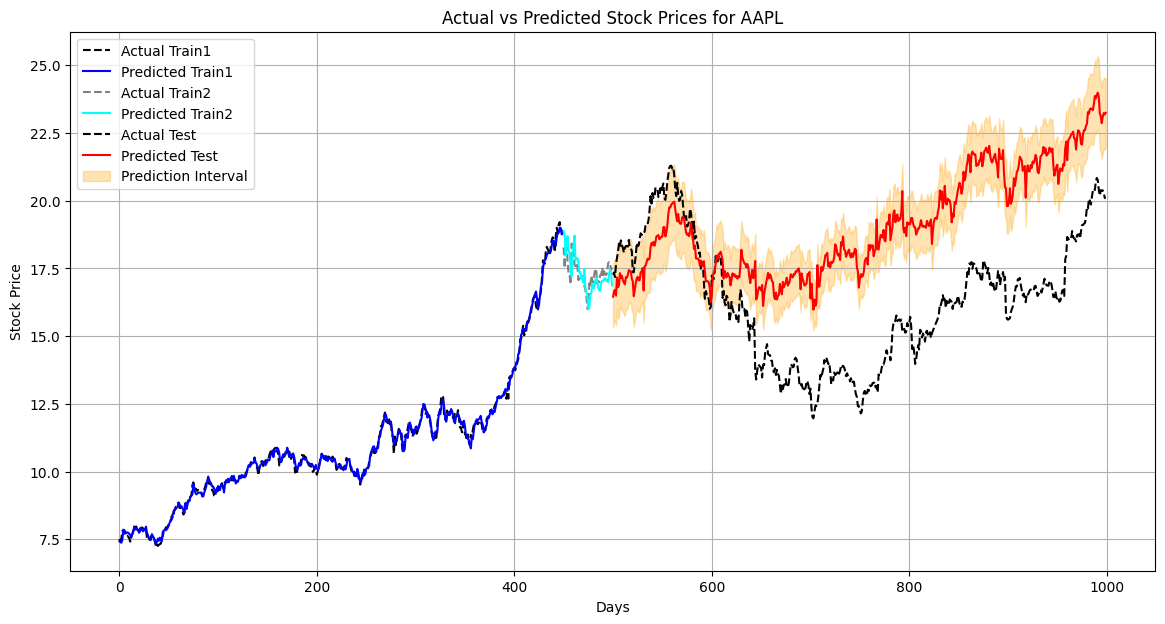

Coverage for the entire test period: 15.60%
Coverage for the first 10% of the test period: 42.00%


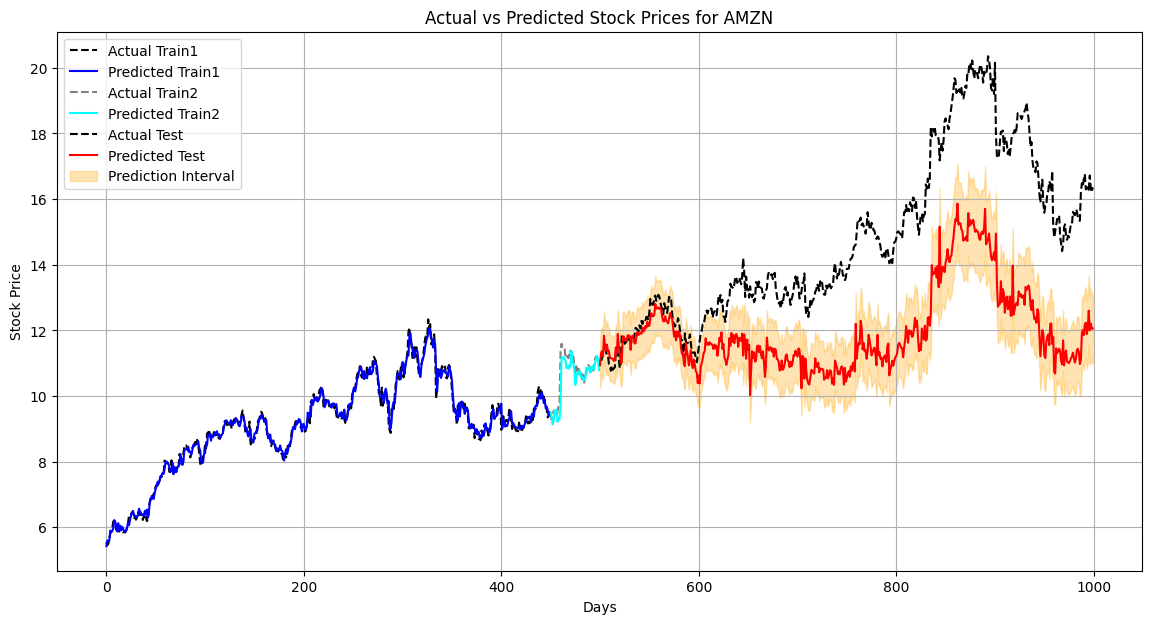

Coverage for the entire test period: 19.20%
Coverage for the first 10% of the test period: 98.00%


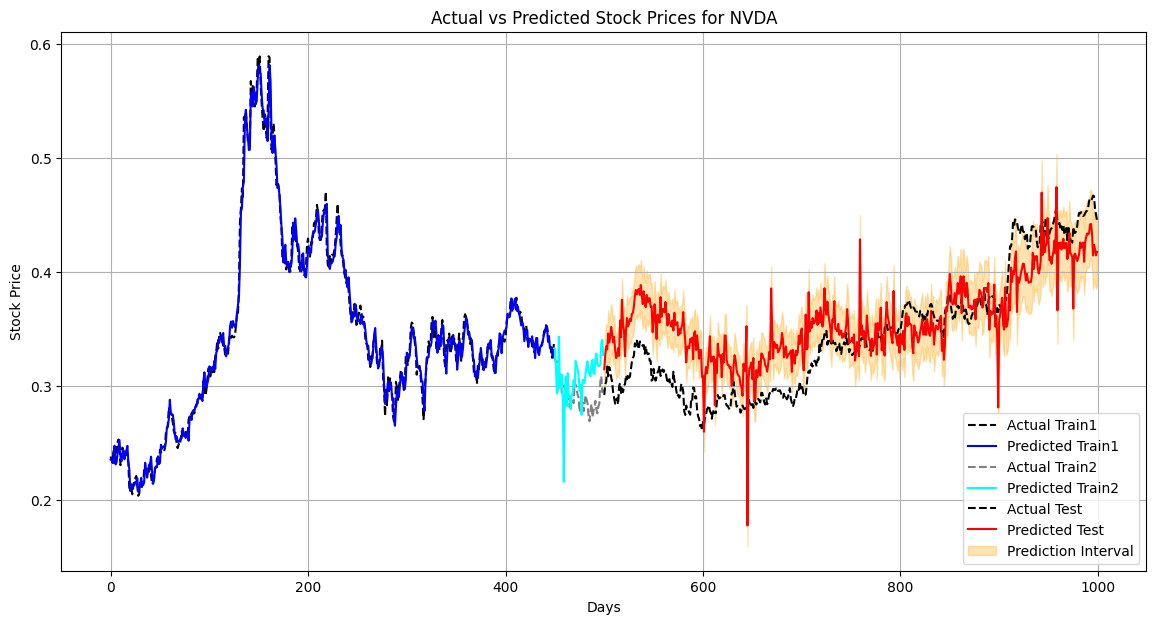

Coverage for the entire test period: 45.60%
Coverage for the first 10% of the test period: 2.00%


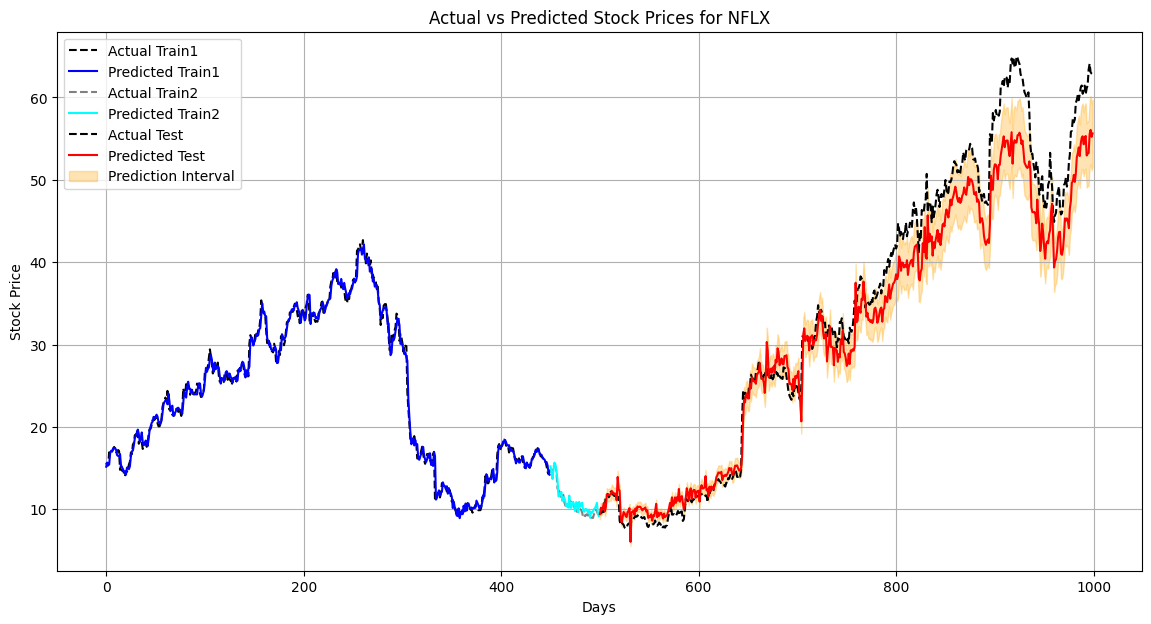

Coverage for the entire test period: 32.80%
Coverage for the first 10% of the test period: 34.00%


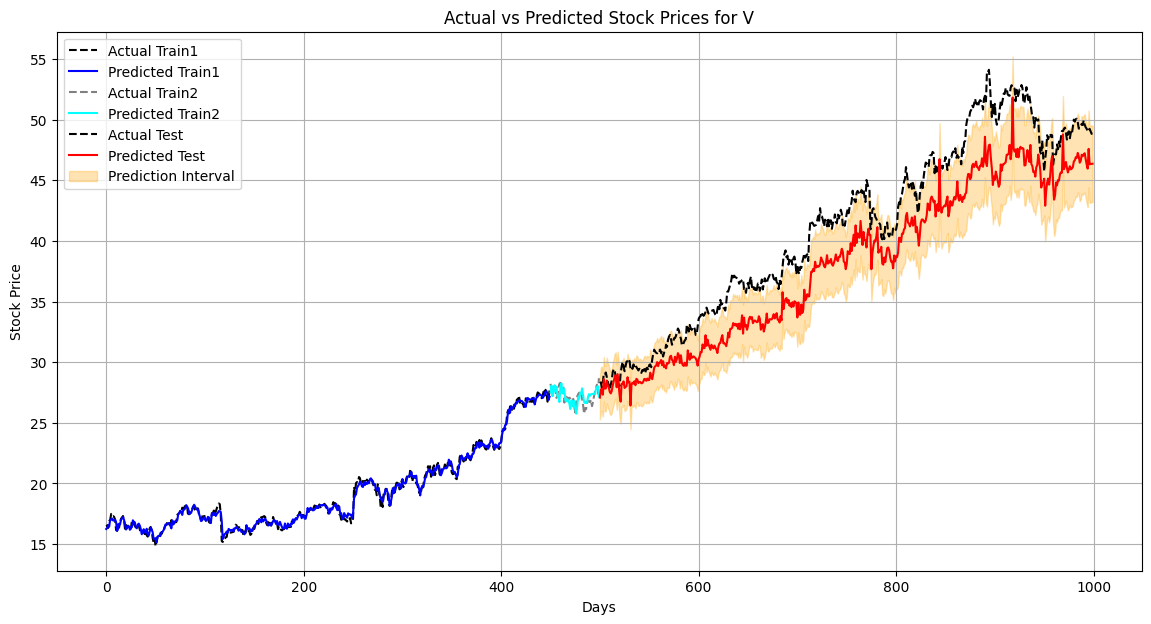

Coverage for the entire test period: 34.20%
Coverage for the first 10% of the test period: 94.00%


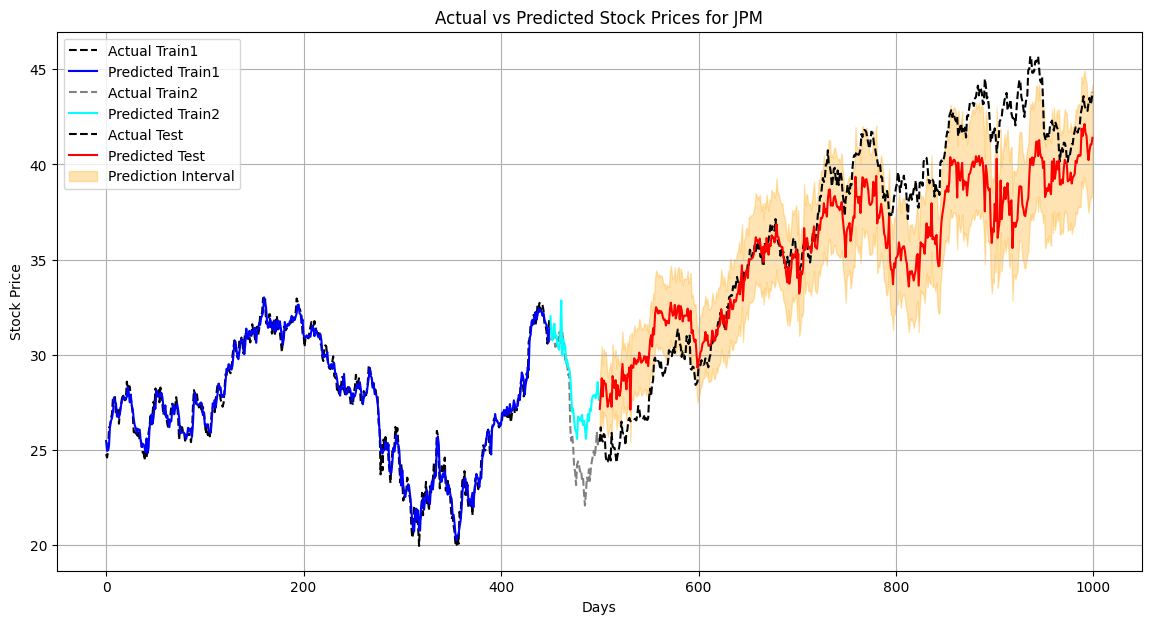

Coverage for the entire test period: 51.80%
Coverage for the first 10% of the test period: 4.00%


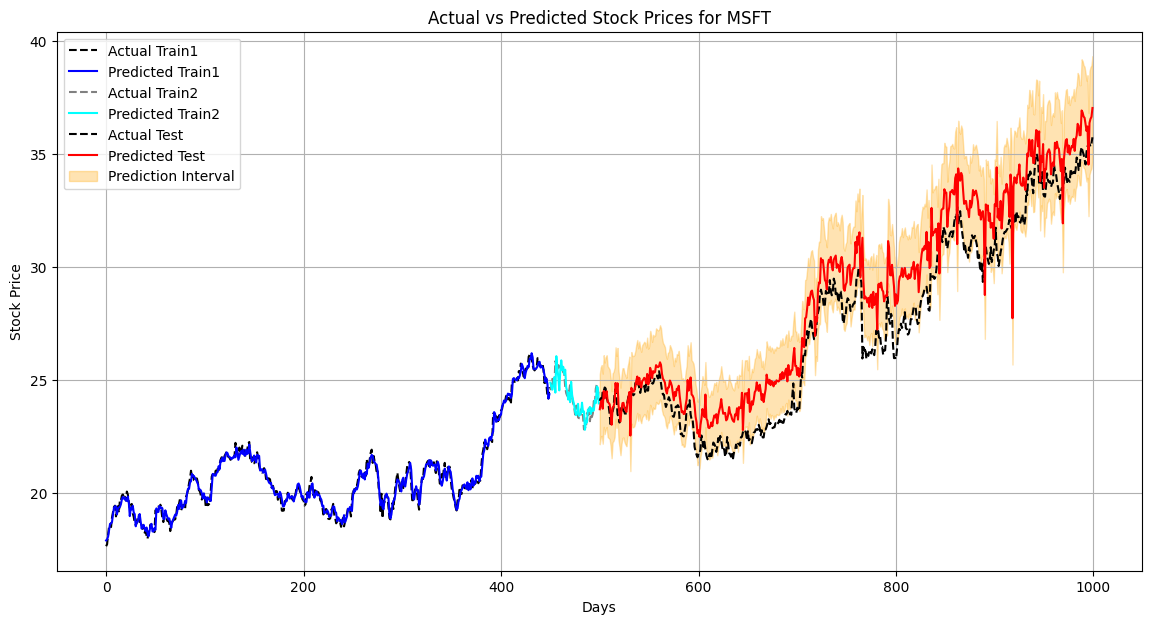

Coverage for the entire test period: 65.60%
Coverage for the first 10% of the test period: 98.00%


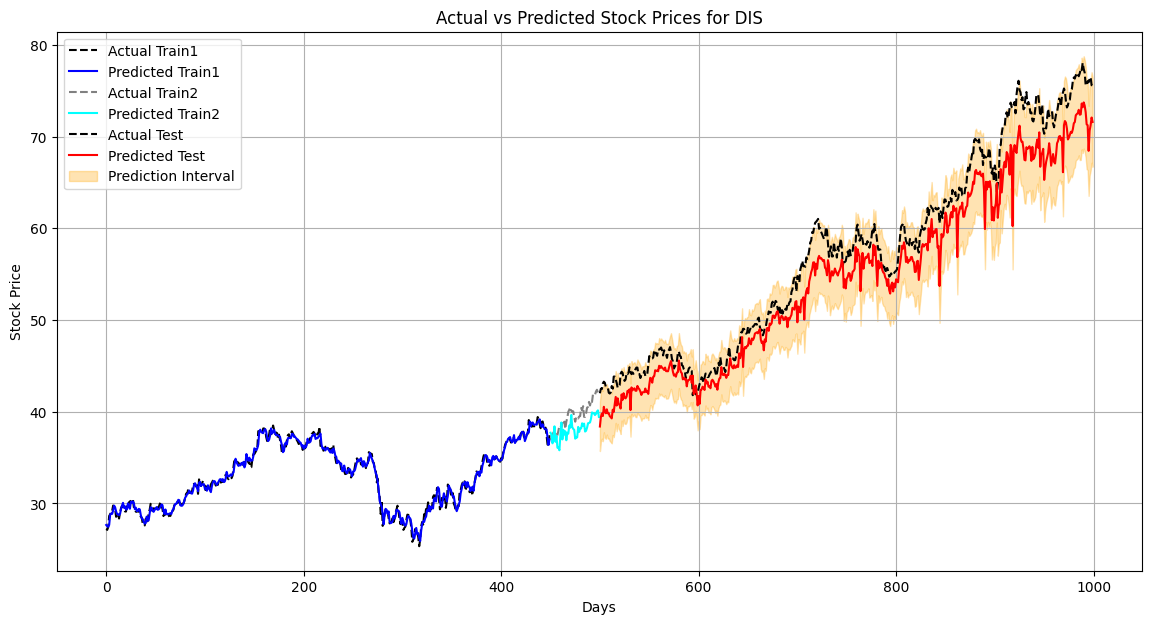

Coverage for the entire test period: 84.00%
Coverage for the first 10% of the test period: 74.00%


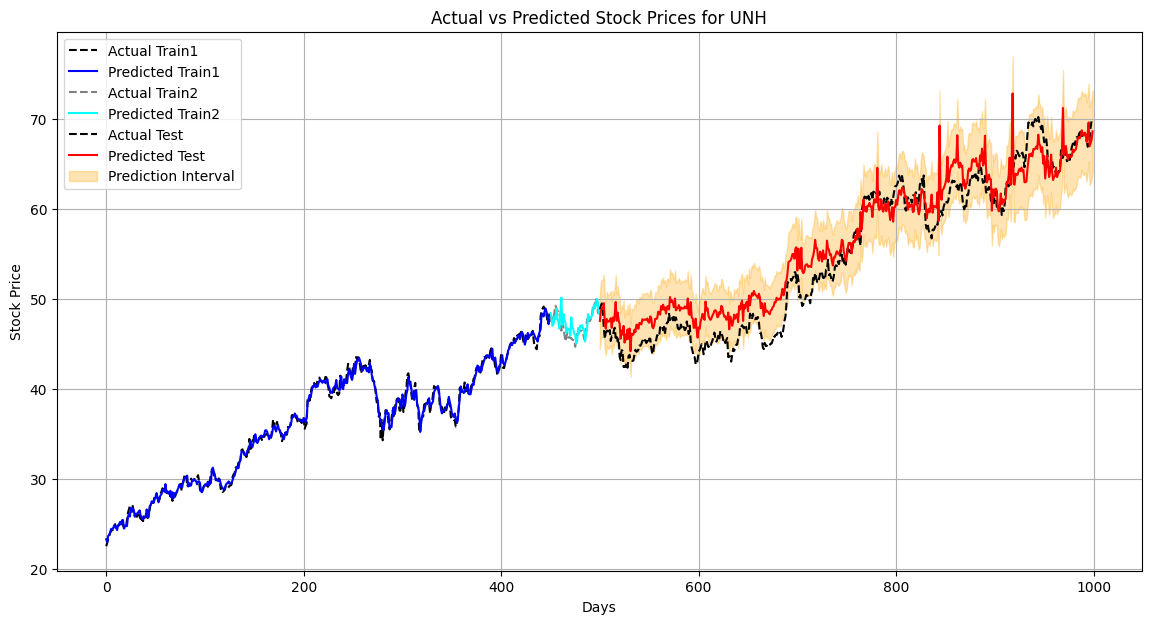

Coverage for the entire test period: 80.00%
Coverage for the first 10% of the test period: 76.00%


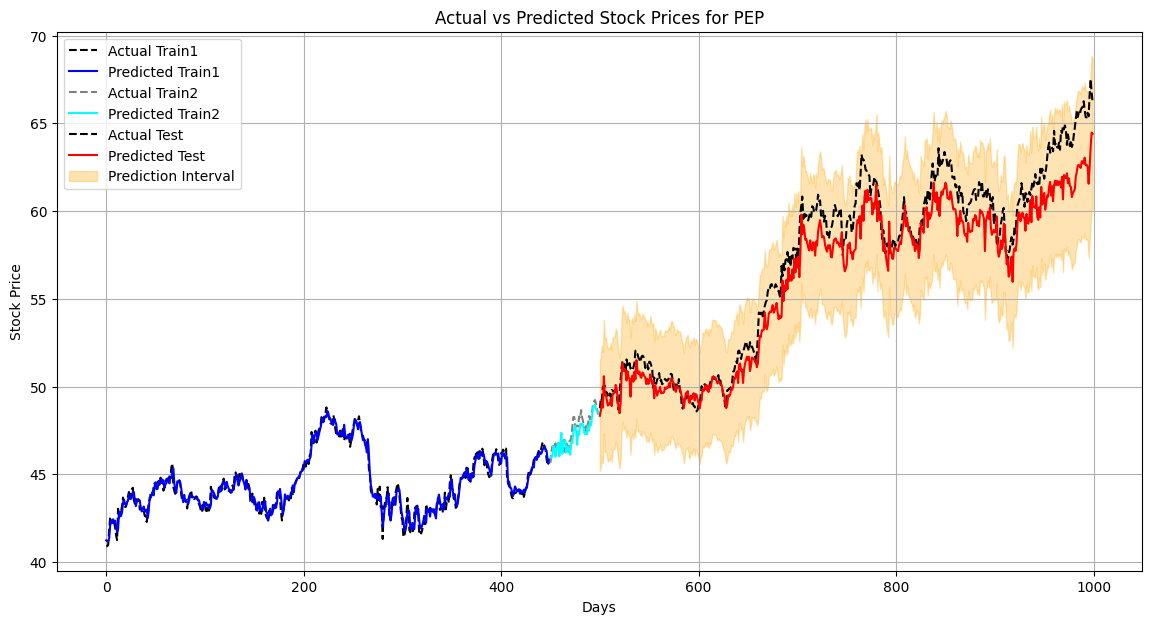

Coverage for the entire test period: 99.80%
Coverage for the first 10% of the test period: 100.00%


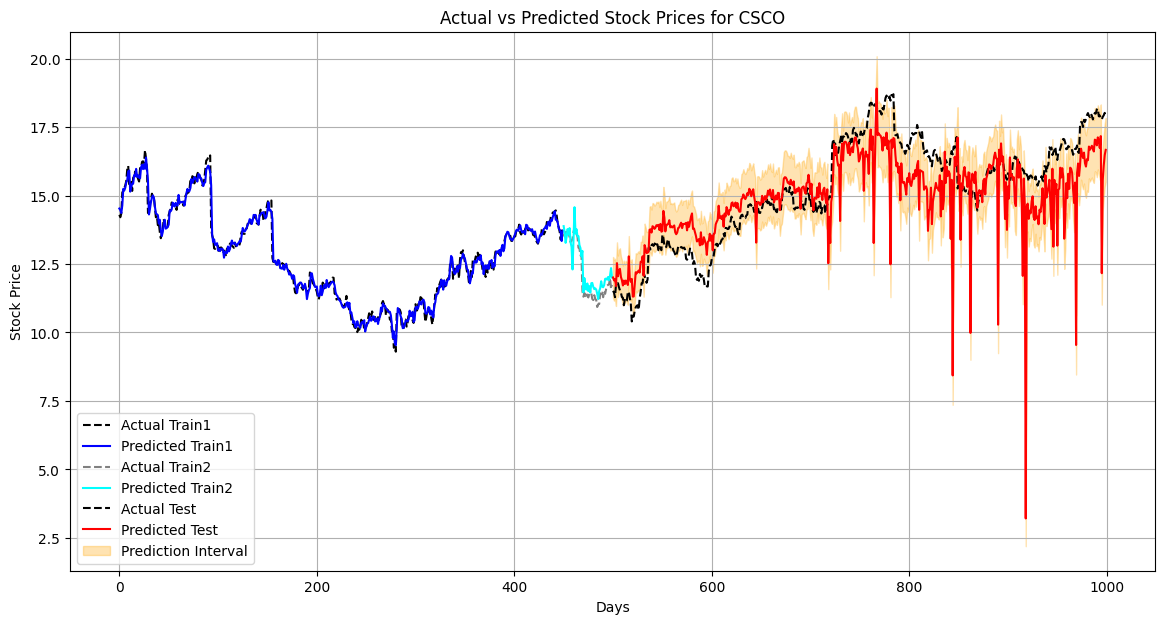

Coverage for the entire test period: 60.80%
Coverage for the first 10% of the test period: 52.00%


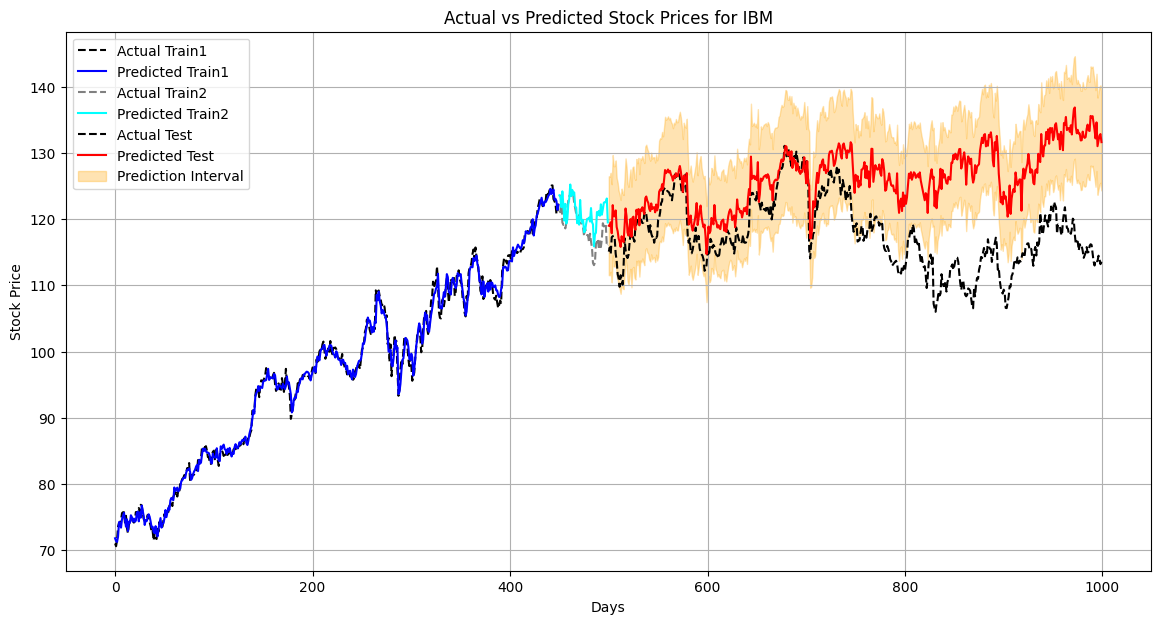

Coverage for the entire test period: 51.40%
Coverage for the first 10% of the test period: 100.00%


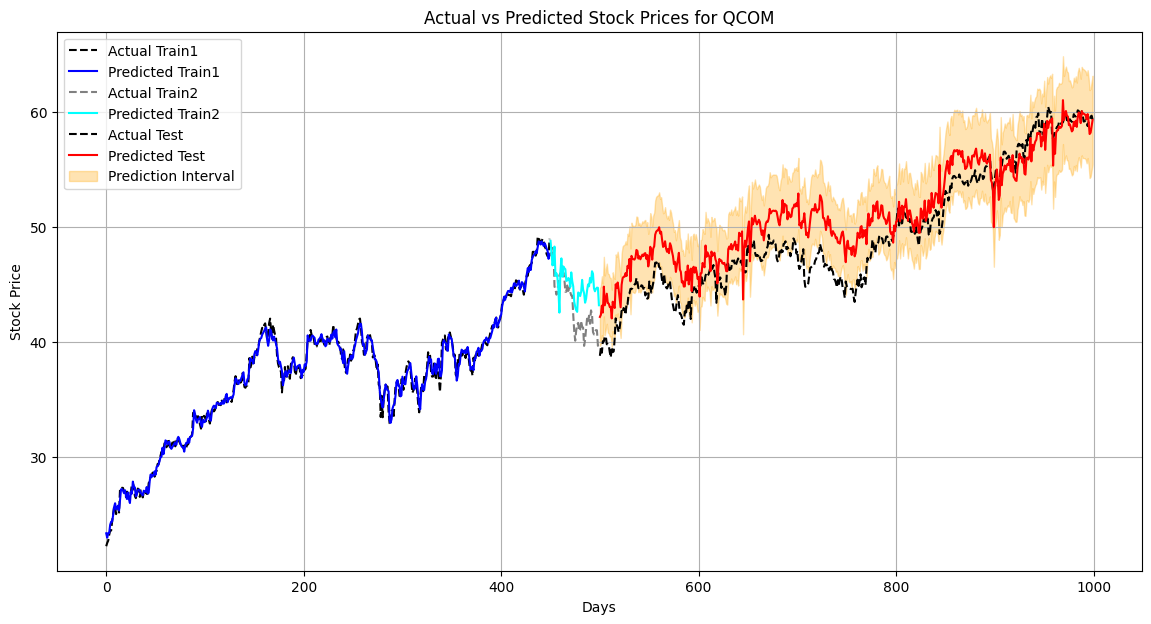

Coverage for the entire test period: 71.20%
Coverage for the first 10% of the test period: 46.00%


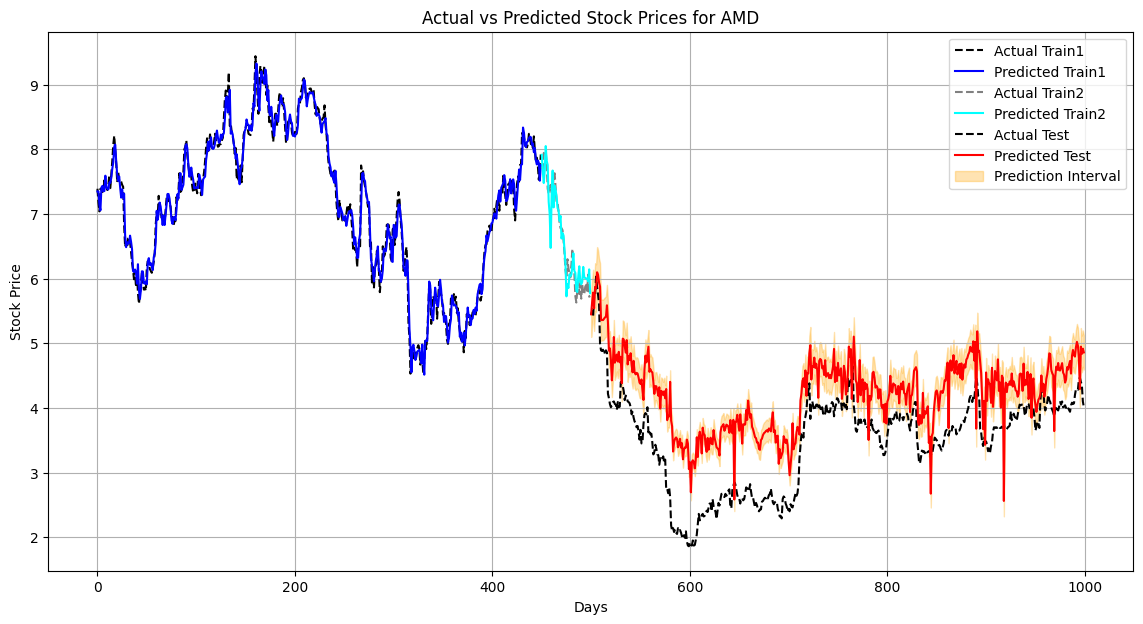

Coverage for the entire test period: 7.00%
Coverage for the first 10% of the test period: 18.00%


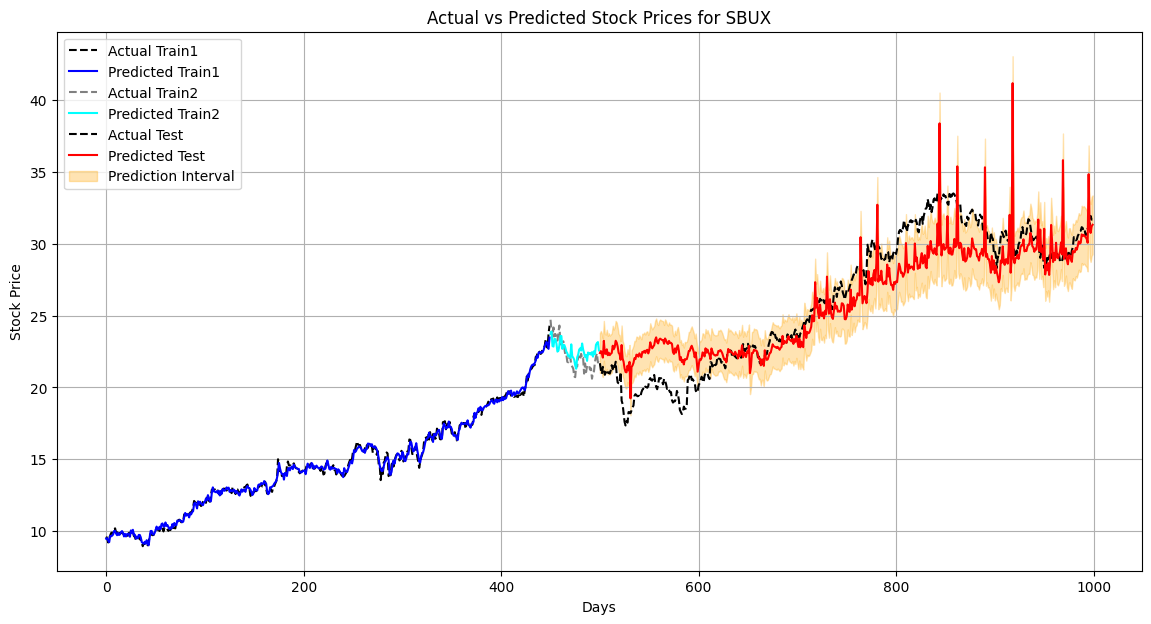

Coverage for the entire test period: 55.00%
Coverage for the first 10% of the test period: 24.00%


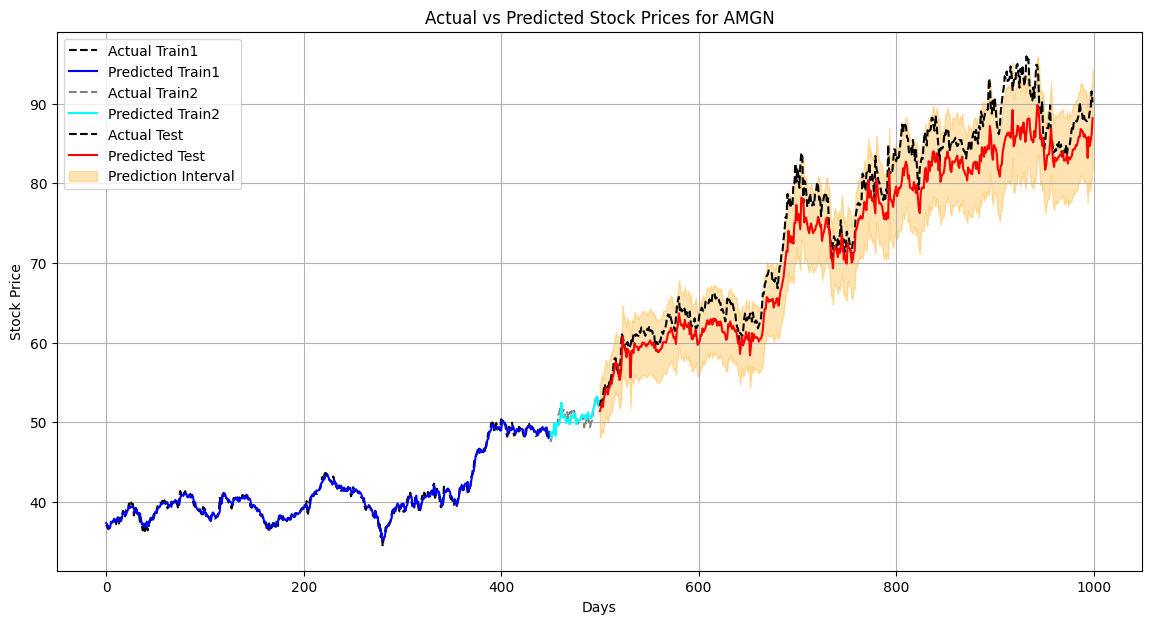

Coverage for the entire test period: 86.80%
Coverage for the first 10% of the test period: 98.00%


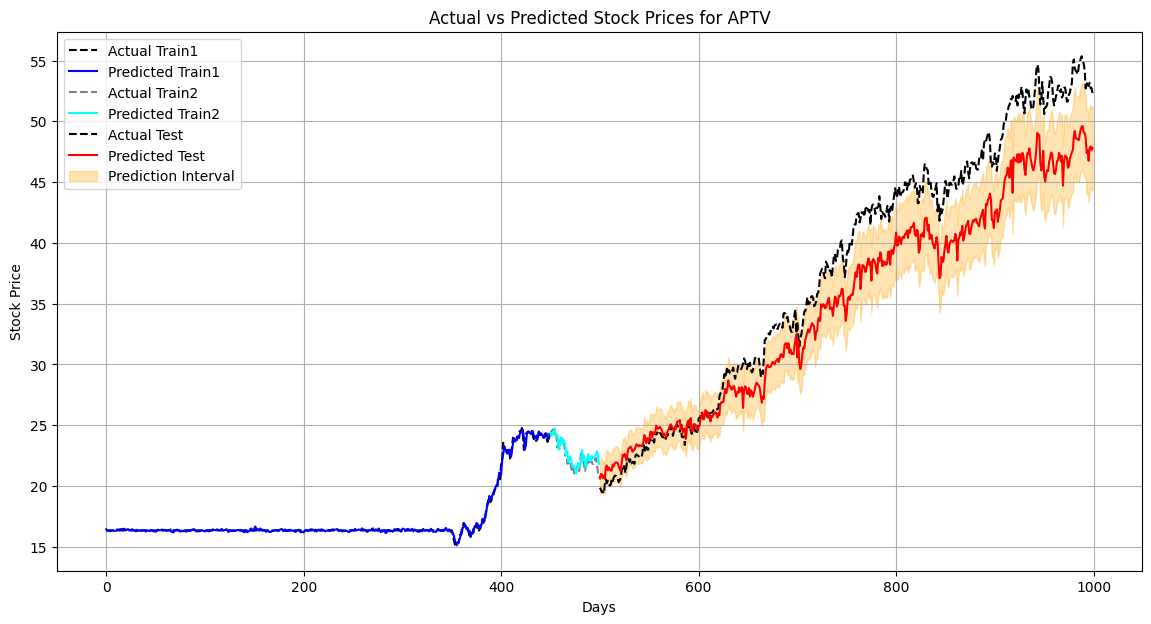

Coverage for the entire test period: 33.00%
Coverage for the first 10% of the test period: 90.00%


In [11]:
# Convert results to DataFrame
if results:
    results_df = pd.DataFrame(results)
    print("Results DataFrame Head:", results_df.head())

    # Save final results
    results_df.to_csv('final_results.csv', index=False)

    # Display the DataFrame in a Jupyter notebook environment
    display(results_df)

    # Plot Mean Squared Errors (MSE) for Google, Apple, and Amazon
    plt.figure(figsize=(12, 8))
    for target in target_tickers:
        plt.plot(results_df[results_df['Target_Ticker'] == target]['Num_Tickers'], results_df[results_df['Target_Ticker'] == target]['MSE_Test'], label=f'MSE Test - {target}', linestyle='solid')

    plt.xlabel('Number of Tickers in Feature Matrix')
    plt.ylabel('Mean Squared Error')
    plt.title('Mean Squared Error as a Function of Number of Tickers in Feature Matrix')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')
    plt.show()

    # Plot the actual vs predicted stock prices for Google, Apple, and Amazon using the last evaluated model
    for target in target_tickers:
        plot_actual_vs_predicted(results_df[results_df['Target_Ticker'] == target]['Predictions'].iloc[-1], target)
else:
    print("No results to display.")
